In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline


from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

# Application dataset
application_train dataset has:
* 307511 observations and 122 features
* No duplicates
* Groups of features have Null values

In [5]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')
help_tool.first_look(application_train)

Dataset has 307511 observations and 122 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
TARGET,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
CODE_GENDER,object,0,0.0
FLAG_OWN_CAR,object,0,0.0
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_WEEK,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,float64,41519,13.5


### Cleaning object features
Before feature selection for Target, object type columns must be handeled. OneHotEncoding is a not good aproach (the dataset has 16 object type features), which would result of column number explosion an would confuse the Light XGB model when fitting for feature importance.

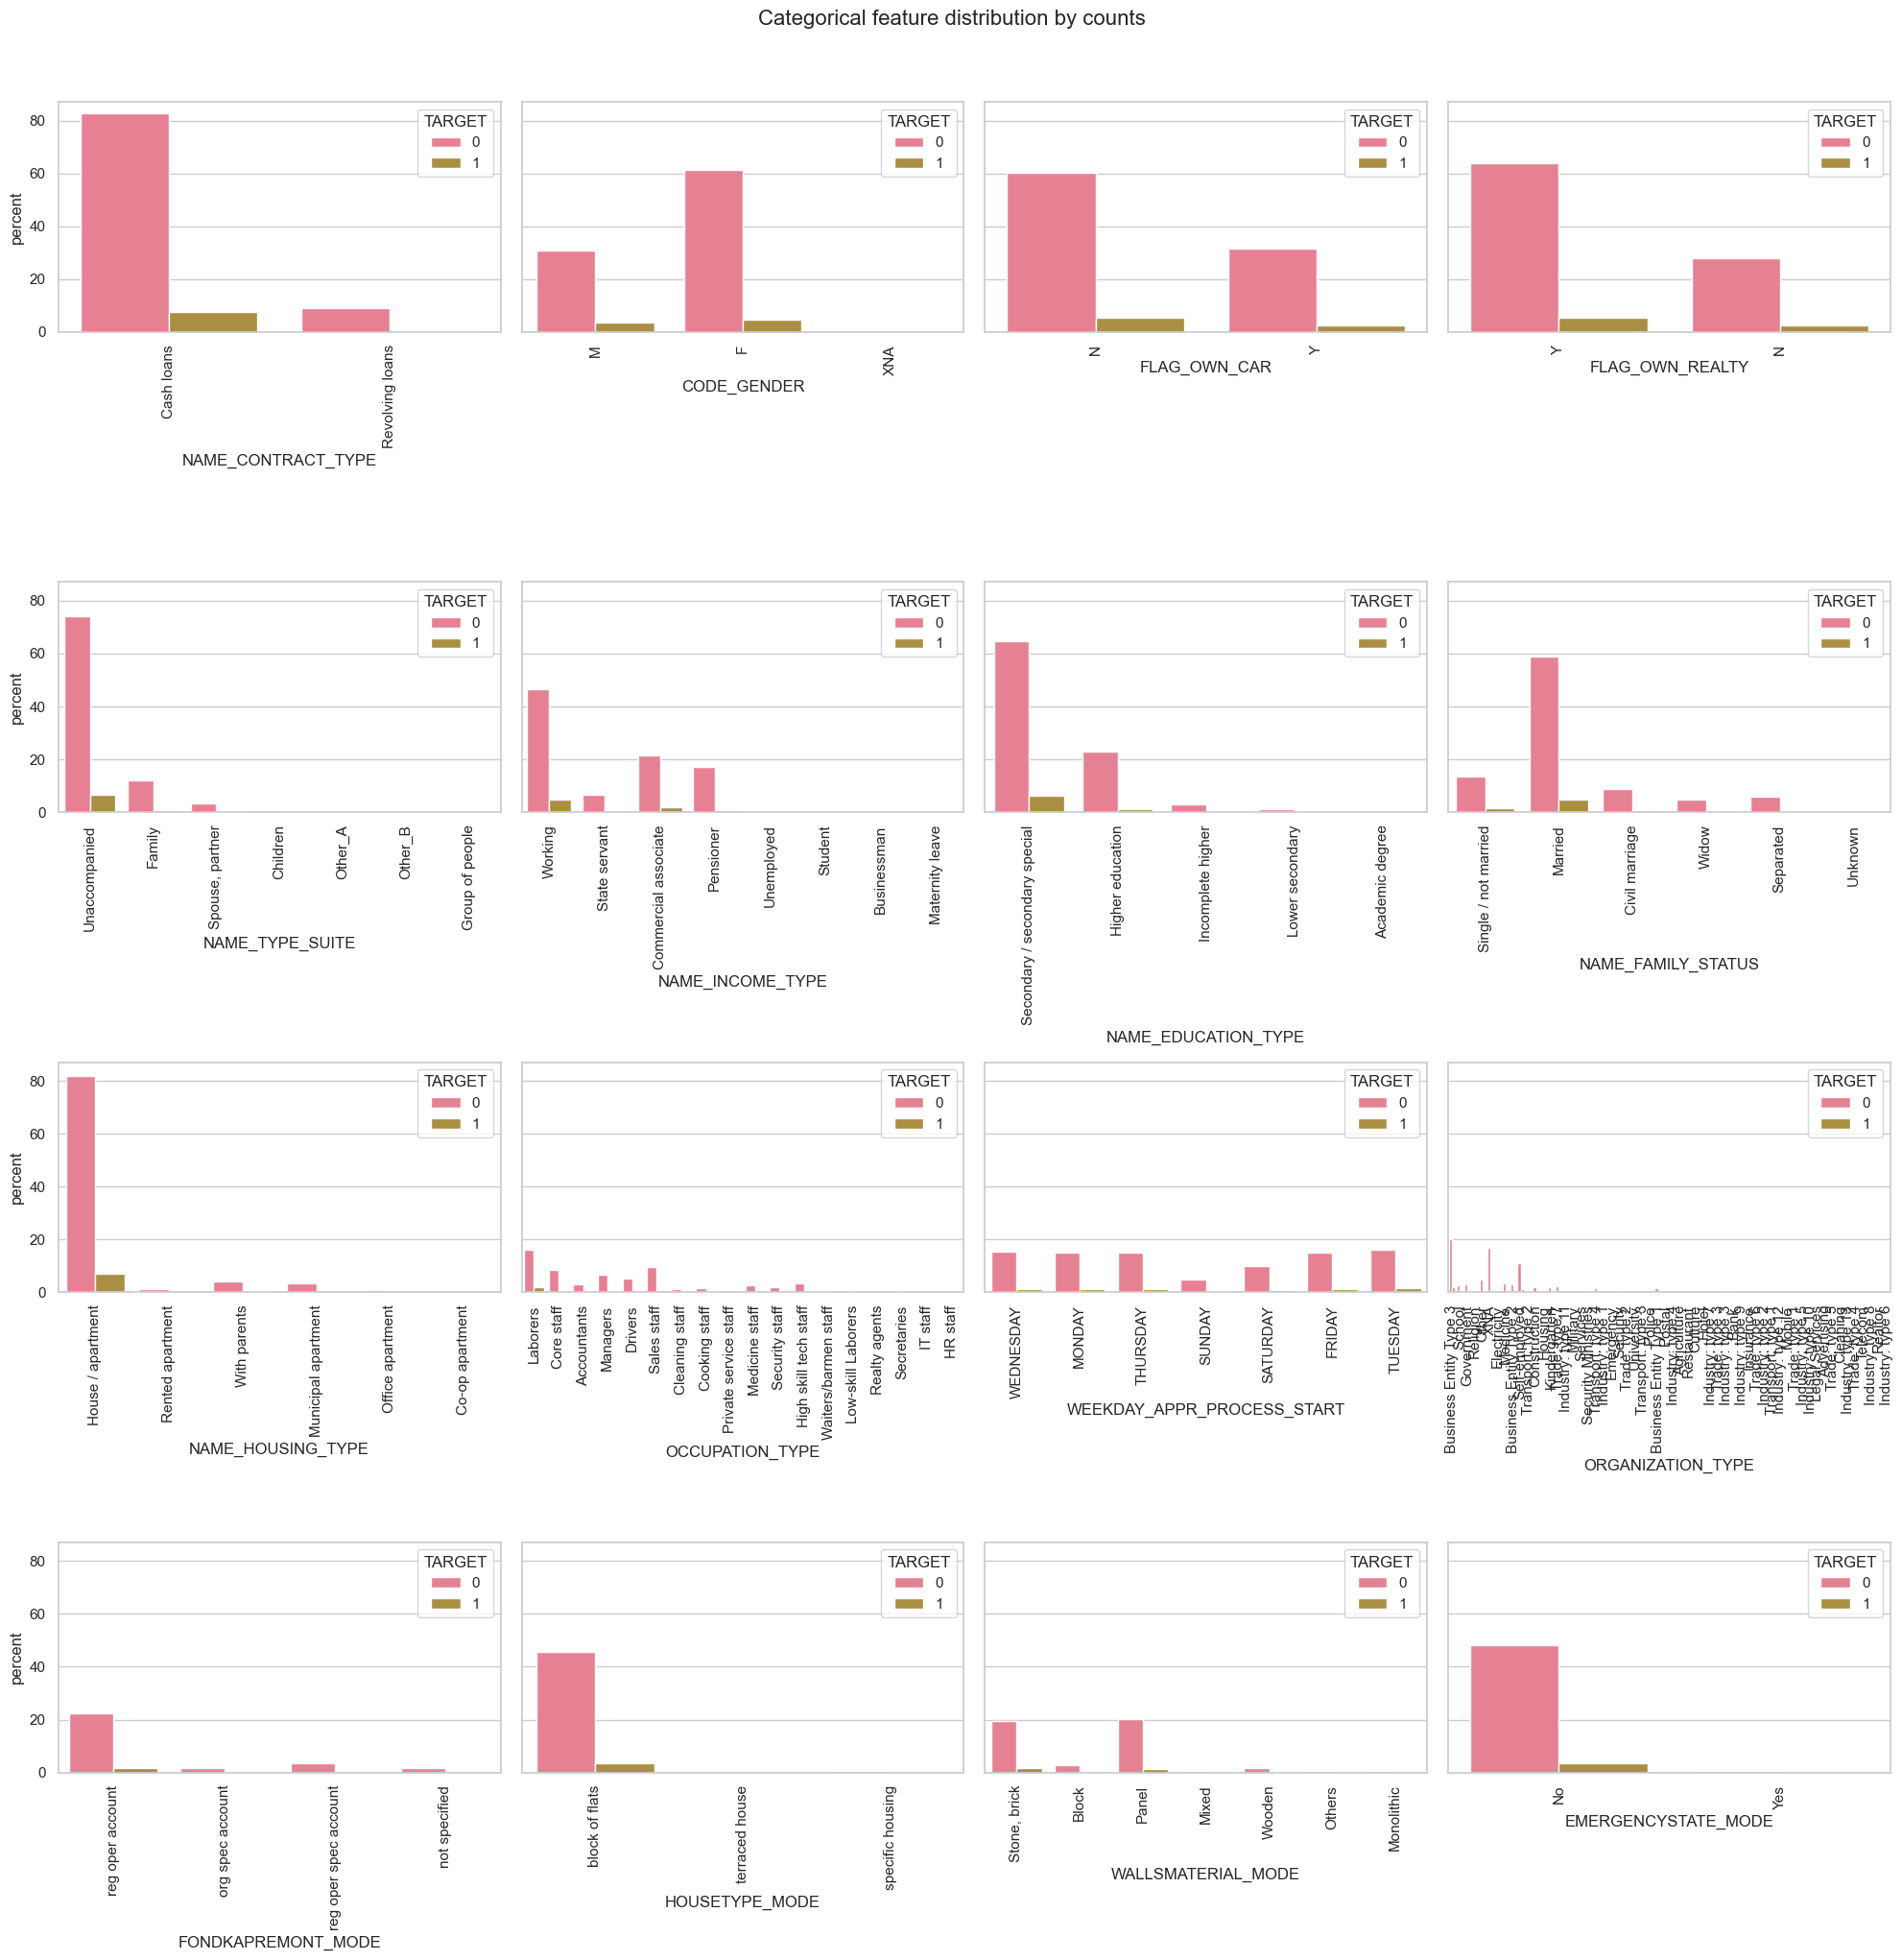

In [3]:
object_columns = application_train.select_dtypes(include=['object']).columns.tolist()

fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.countplot(data=application_train, x=col, 
                 ax=axes[i],  
                 legend=True,
                 stat="percent",
                 hue='TARGET'
                 )
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

From the above plots, it is seen that features are imbalanced on their own distribution, as their's no clear dependency on Target. Thus, feature will be:
* Numerically encoded when posible (Female - not-Female)
* Discrimination could be avoided by categorizing NAME_FAMILY_STATUS to single/not single.
* Education type can be numerically encoded.
* Grouped to subgroups if feature has high Cardinality (number of unique value)

ORGANIZATION_TYPE has high Cardinality, but the highest count organization does not take 30% of the overall ORGANIZATION_TYPE

In [6]:
help_tool.cardinality_test(application_train)

['ORGANIZATION_TYPE']

In [246]:
application_train['ORGANIZATION_TYPE'].value_counts().head() / application_train['ORGANIZATION_TYPE'].count() * 100

ORGANIZATION_TYPE
Business Entity Type 3    22.110429
XNA                       18.007161
Self-employed             12.491260
Other                      5.425172
Medicine                   3.639870
Name: count, dtype: float64

In [247]:
#application_train = help_tool.encode_categories(application_train)

In [248]:
#application_train['OCCUPATION_GROUP'].value_counts() / application_train['OCCUPATION_GROUP'].count() * 100

It's not clear how to cattegorize NAME_INCOME_TYPE as some of the categories sound similar.

In [249]:
# plt.figure(figsize=(15, 5))

# sns.barplot(data=application_train.sample(100000, random_state=42), hue='OCCUPATION_GROUP', y='AMT_INCOME_TOTAL', x='NAME_INCOME_TYPE')

# #plt.yscale('log')
# plt.xticks(rotation=90)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

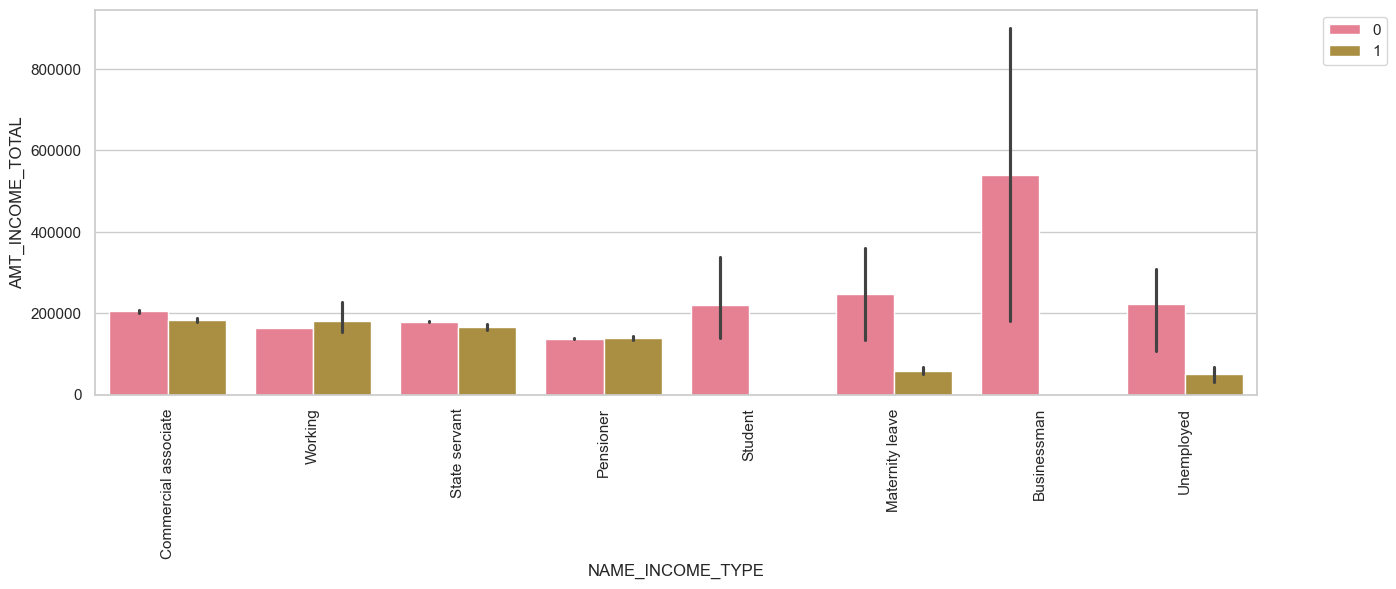

In [250]:
plt.figure(figsize=(15, 5))

sns.barplot(data=application_train.sample(100000, random_state=42), hue='TARGET', y='AMT_INCOME_TOTAL', x='NAME_INCOME_TYPE')

#plt.yscale('log')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Is there a difference in 'Working' and 'Commercial associate' in terms of Target?

In [251]:
from scipy.stats import ttest_ind

filtered_data = application_train[application_train['NAME_INCOME_TYPE'].isin(['Working', 'State servent'])]
cross_tab = pd.crosstab(filtered_data['NAME_INCOME_TYPE'], filtered_data['TARGET'])
print(cross_tab)

from scipy.stats import chi2_contingency

# Perform Chi-Square test
chi2, p, dof, ex = chi2_contingency(cross_tab)
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")


TARGET                 0      1
NAME_INCOME_TYPE               
Working           143550  15224
Chi2 Statistic: 0.0
P-value: 1.0


In [252]:
filtered_data = application_train[application_train['NAME_INCOME_TYPE'].isin(['State servent', 'Commercial associate'])]
cross_tab = pd.crosstab(filtered_data['NAME_INCOME_TYPE'], filtered_data['TARGET'])
print(cross_tab)

from scipy.stats import chi2_contingency

# Perform Chi-Square test
chi2, p, dof, ex = chi2_contingency(cross_tab)
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")

TARGET                    0     1
NAME_INCOME_TYPE                 
Commercial associate  66257  5360
Chi2 Statistic: 0.0
P-value: 1.0


so we have to keep the values

In [253]:
application_train = help_tool.encode_categories(application_train)

In [258]:
# object_columns = application_train.select_dtypes(include=['object']).columns.tolist()
# application_train_w_dummies = help_tool.dummy_columns(application_train, object_columns)


# application_train_w_dummies.columns = application_train_w_dummies.columns.str.replace(',', '_').str.replace(' ', '_')

In [259]:
y = application_train['TARGET']
X = application_train.drop(columns=['TARGET', 'SK_ID_CURR'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Display the top 10 most important features
# print("Top 10 most important features:")
# print(feature_importance.head(10))


In [260]:
feature_importance.head(30)

,feature,importance
36,EXT_SOURCE_1,369
38,EXT_SOURCE_3,281
37,EXT_SOURCE_2,270
12,DAYS_BIRTH,208
4,AMT_CREDIT,205
5,AMT_ANNUITY,164
6,AMT_GOODS_PRICE,158
13,DAYS_EMPLOYED,125
15,DAYS_ID_PUBLISH,119
16,OWN_CAR_AGE,110


In [261]:
feature_importance[feature_importance['importance'] == 0]

,feature,importance
7,NAME_TYPE_SUITE,0
17,FLAG_MOBIL,0
18,FLAG_EMP_PHONE,0
20,FLAG_CONT_MOBILE,0
34,LIVE_CITY_NOT_WORK_CITY,0
30,REG_REGION_NOT_WORK_REGION,0
31,LIVE_REGION_NOT_WORK_REGION,0
118,FONDKAPREMONT_reg_oper_account,0
108,FLAG_DOCUMENT_21,0
107,FLAG_DOCUMENT_20,0


# Flag columns

In [230]:
# flag_doc_columns = application_train.filter(like='FLAG_DOCUMENT', axis=1).columns
# application_train[flag_doc_columns].sum(axis=1).value_counts()

In [231]:
# flag_documnets = application_train.filter(like='FLAG_DOCUMENT', axis=1).replace({1: np.nan})

# msno.matrix(flag_documnets)
# plt.show()

# AMT_

In [232]:
# amt = application_train.filter(like='AMT_', axis=1)
# amt.isnull().sum()

# Derivative normalized features
## APARTMENTS_

Features are derived from the same source. All of APARTMENTS_ features are highly correlated.

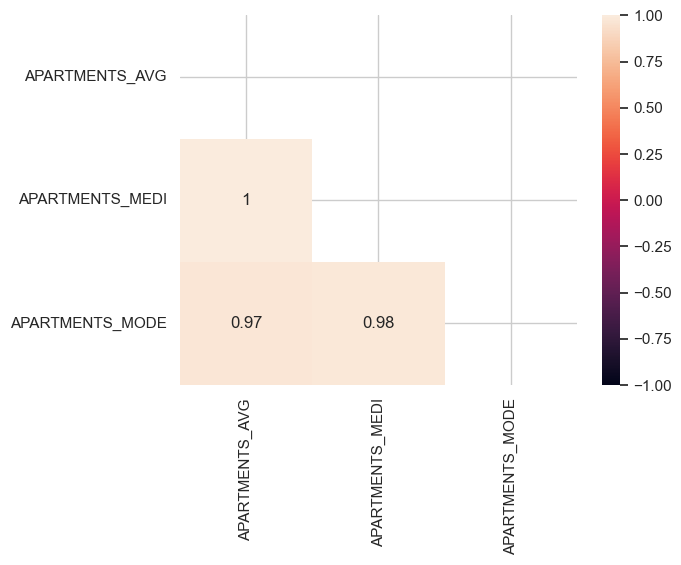

In [233]:
corr = application_train[['APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE']].corr()

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=np.triu(corr))
plt.show()

Distribution of Data:
* Normal Distribution: If the normalized apartment sizes follow a roughly normal (Gaussian) distribution, the average is a suitable measure of central tendency. The average is sensitive to all values and provides a good overall representation when the data is symmetrically distributed.
* Skewed Distribution: If the normalized apartment sizes are skewed (either positively or negatively), the median is often more appropriate. The median is less affected by outliers and skewed data, giving a better sense of the typical apartment size in such cases.

Presence of Outliers:
* Average: Highly sensitive to outliers. If there are extreme values, the average can be distorted, potentially giving a misleading sense of the central tendency.
* Median: Robust to outliers. It remains representative of the central location of the data even in the presence of extreme values.

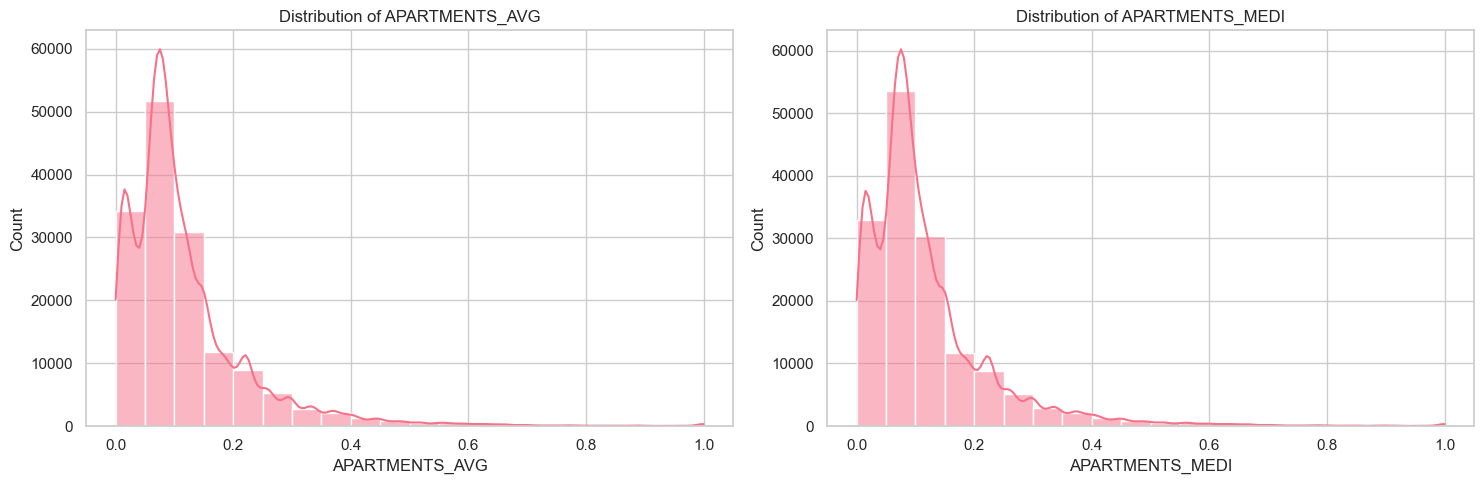

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for 'APARTMENTS_AVG'
sns.histplot(data=application_train, x='APARTMENTS_AVG', kde=True, bins=20, ax=axes[0])
axes[0].set_title('Distribution of APARTMENTS_AVG')

# Plot for 'APARTMENTS_MEDI'
sns.histplot(data=application_train, x='APARTMENTS_MEDI', kde=True, bins=20, ax=axes[1])
axes[1].set_title('Distribution of APARTMENTS_MEDI')

plt.tight_layout()
plt.show()

In [235]:
application_train.drop(columns=['APARTMENTS_AVG', 'APARTMENTS_MODE'], inplace=True)

## Area deivatives
Rest of area derivative are skewed. Mean feature will be used, Average and Mode will be removed.

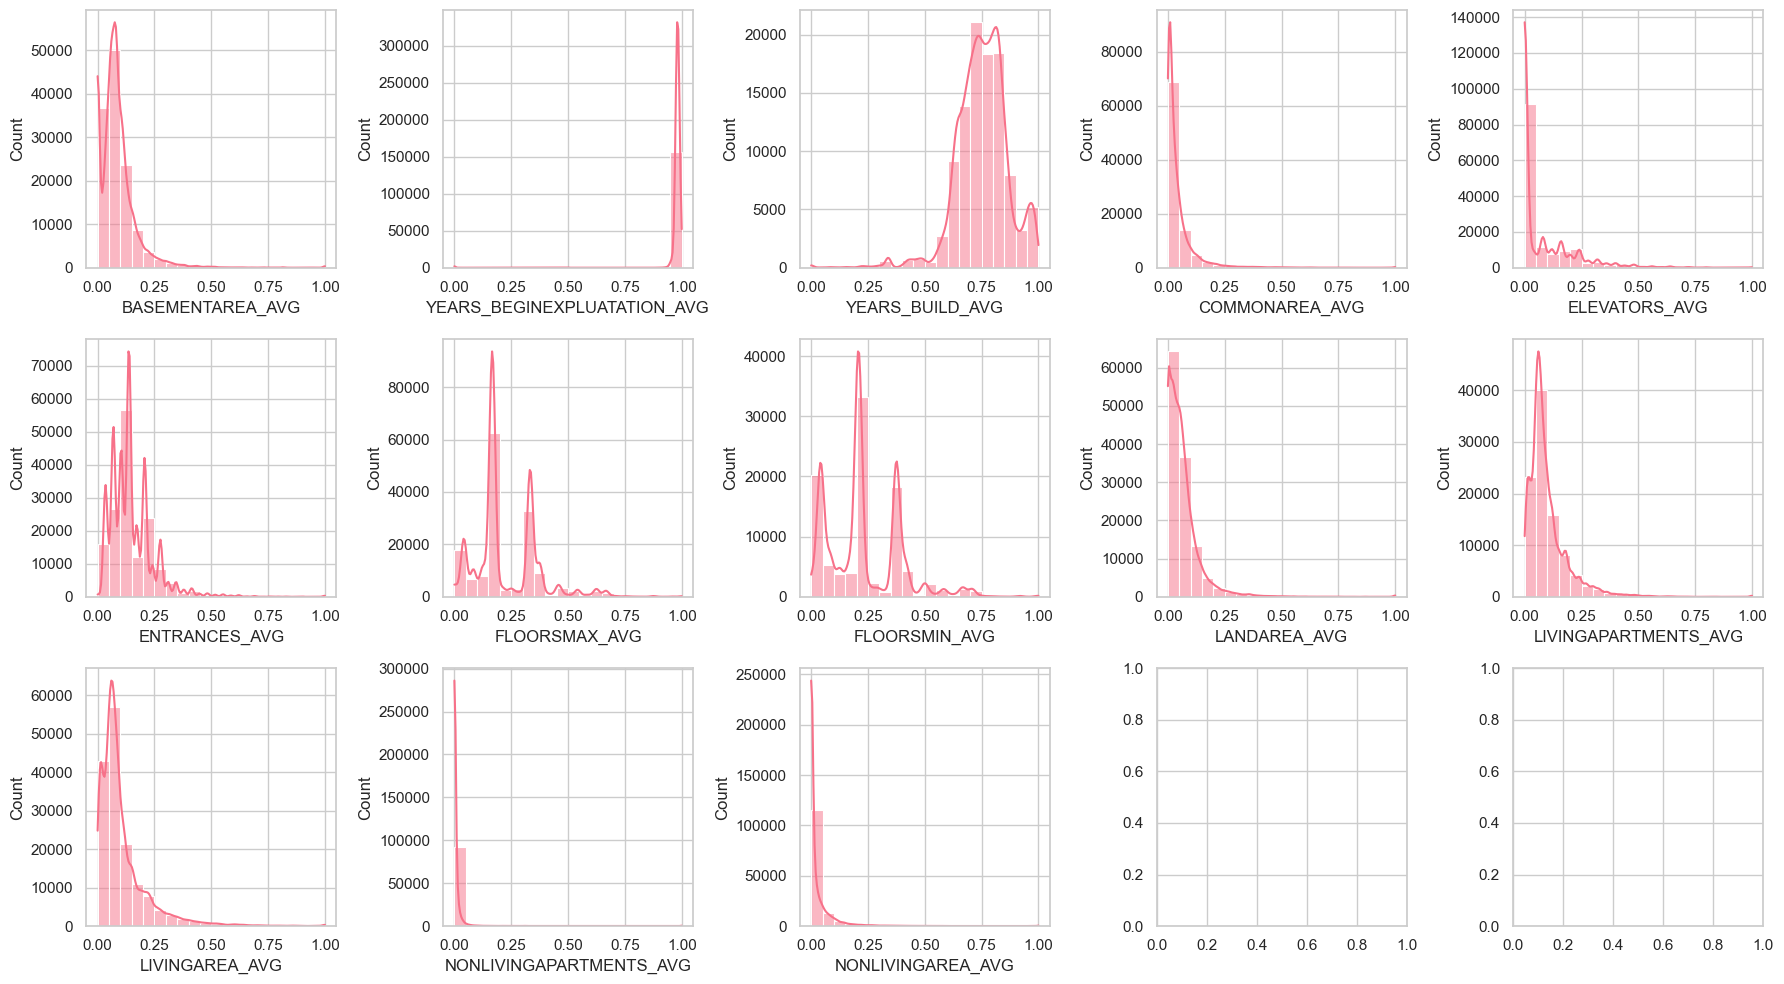

In [236]:
fig, axes = plt.subplots(3, 5, figsize=(18, 10))

features = application_train.filter(like='_AVG', axis=1).columns.to_list()

for i, feature in enumerate(features):
    row = i // 5  
    col = i % 5 
    
    sns.histplot(data=application_train, x=feature, kde=True, bins=20, ax=axes[row, col])

plt.tight_layout()
plt.show()

YEARS_BEGINEXPLUATATION_AVG


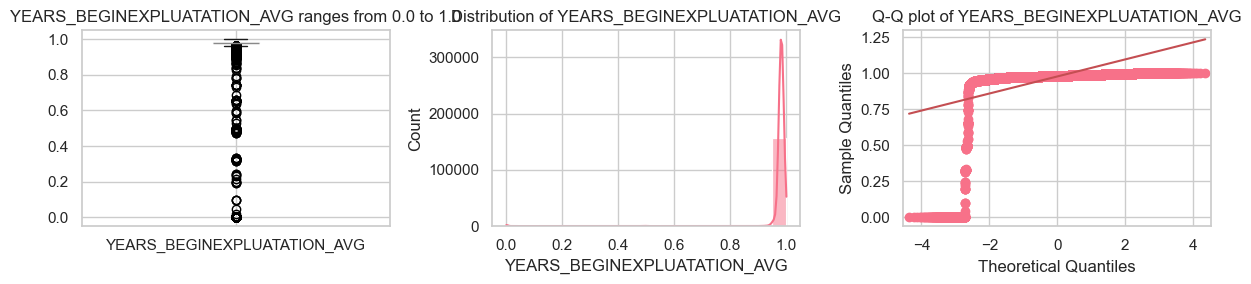

NONLIVINGAPARTMENTS_AVG


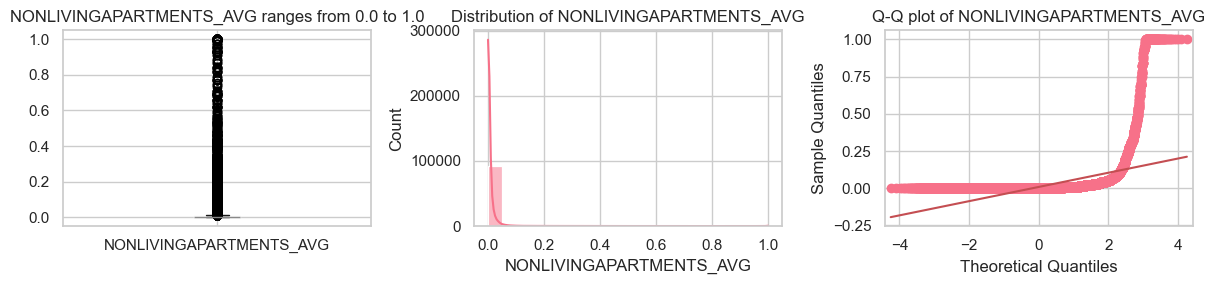

In [237]:
help_visuals.distribution_check(application_train[['YEARS_BEGINEXPLUATATION_AVG', 'NONLIVINGAPARTMENTS_AVG']])

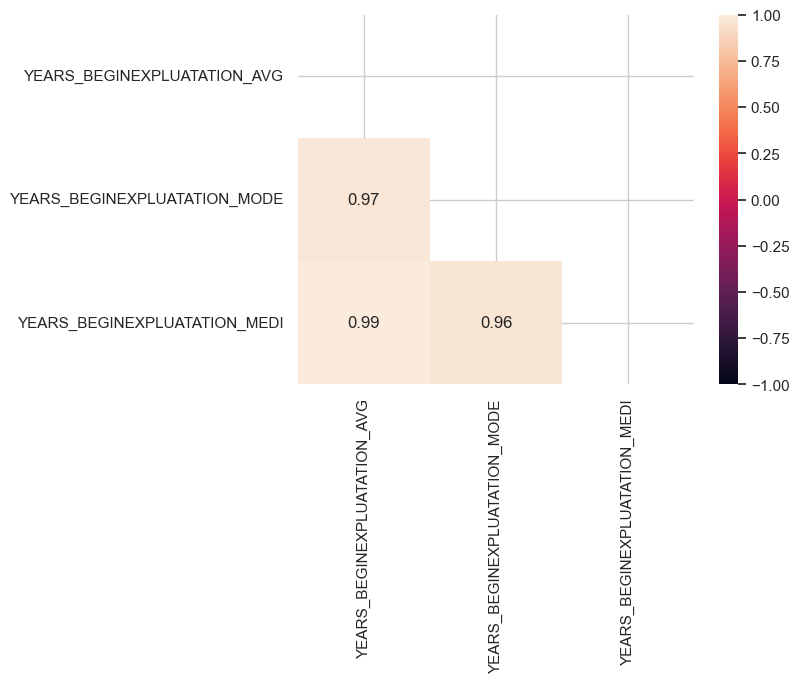

In [238]:
help_visuals.derivative_feature_corr(application_train, 'YEARS_BEGINEXPLUATATION_')

Remove AVG and MODE features, when coresponding MEDI is available

In [239]:
application_train.drop(columns=application_train.filter(like='_AVG').columns.str.replace('AVG', 'MODE').to_list(), inplace=True)
application_train.drop(columns=application_train.filter(like='_AVG').columns, inplace=True)

## Mode

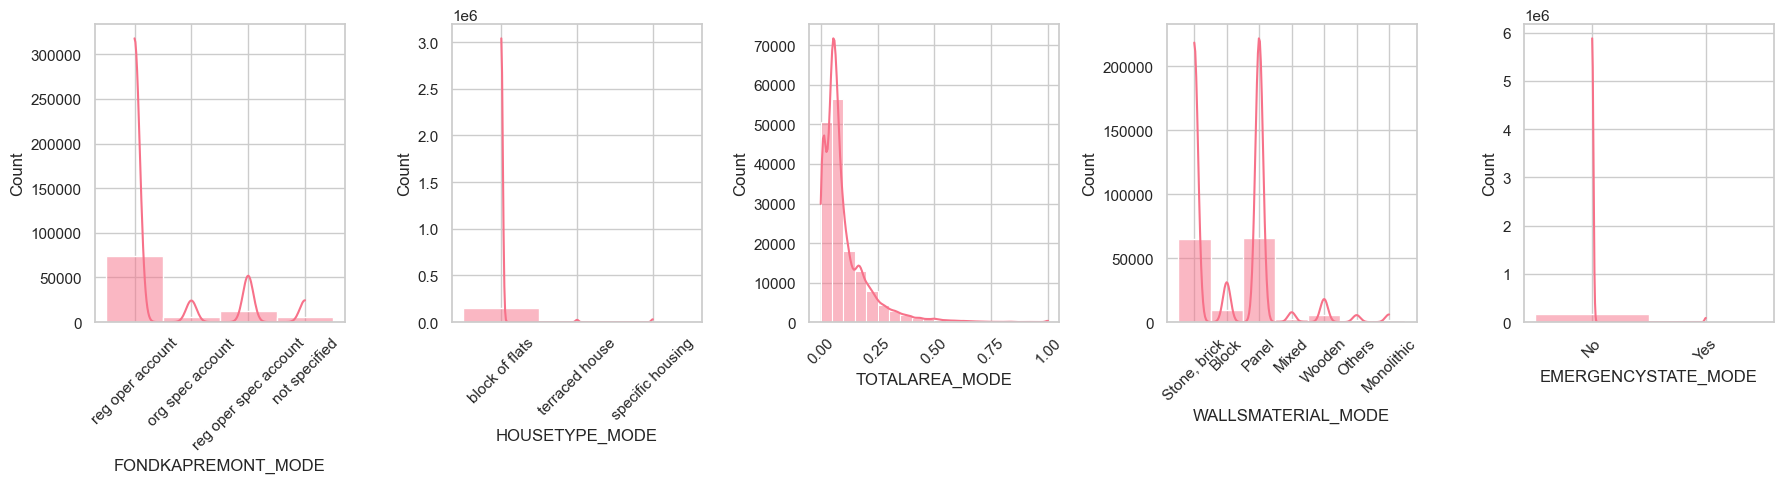

In [240]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

features = application_train.filter(like='_MODE', axis=1).columns.to_list()

for i, feature in enumerate(features):
    sns.histplot(data=application_train, x=feature, kde=True, bins=20, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [241]:
application_train['EMERGENCYSTATE_MODE'] = application_train['EMERGENCYSTATE_MODE'].replace({'Yes': 1, 'No': 0}).astype(float)

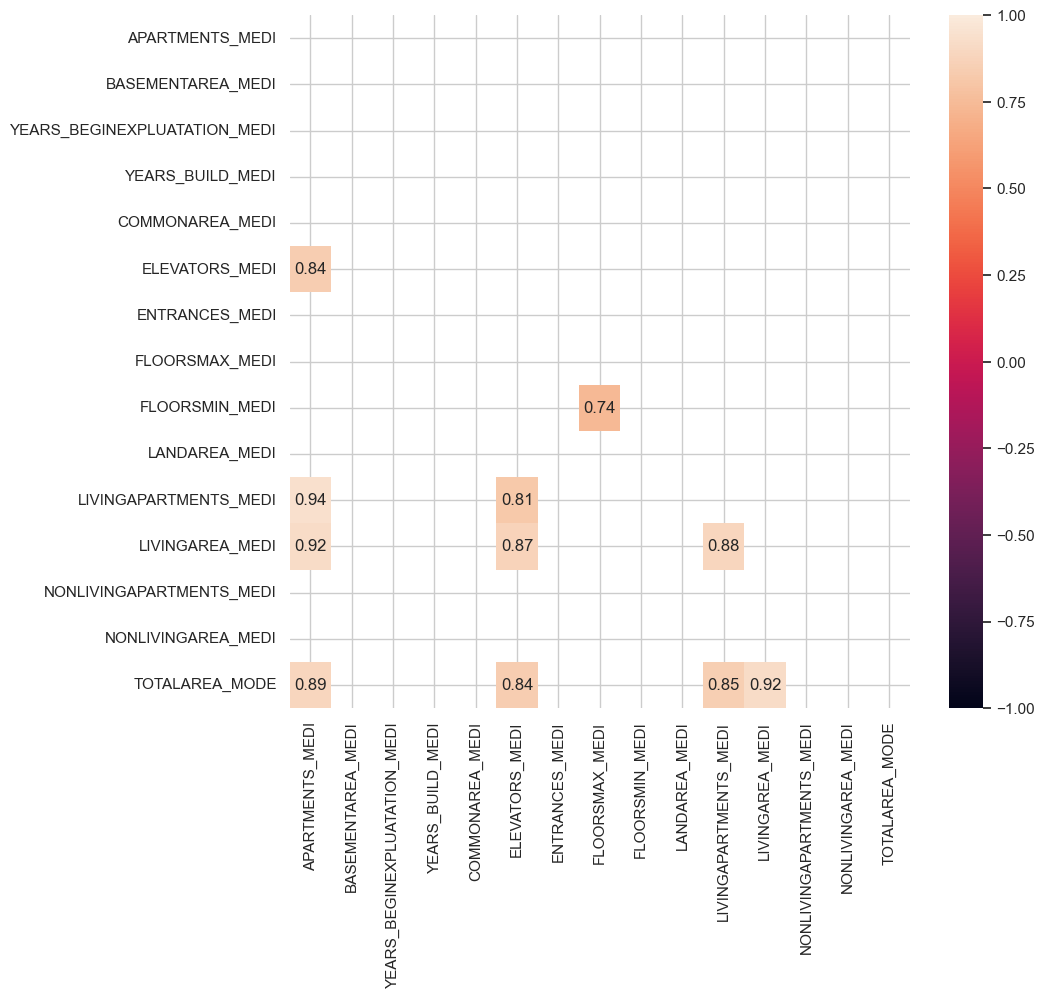

In [242]:
plt.figure(figsize=(10, 9))

corr = application_train[application_train.filter(like='MEDI', axis=1).columns.to_list() + ['TOTALAREA_MODE']].corr()

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=~(np.tril(corr) & (corr.abs() > 0.7)  & (corr.abs() < 1)))
plt.show()

ELEVATORS_MEDI has different density distribution than the rest, but LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, TOTALAREA_MODE have similar shapes, TOTALAREA_MODE will be left from the 3.

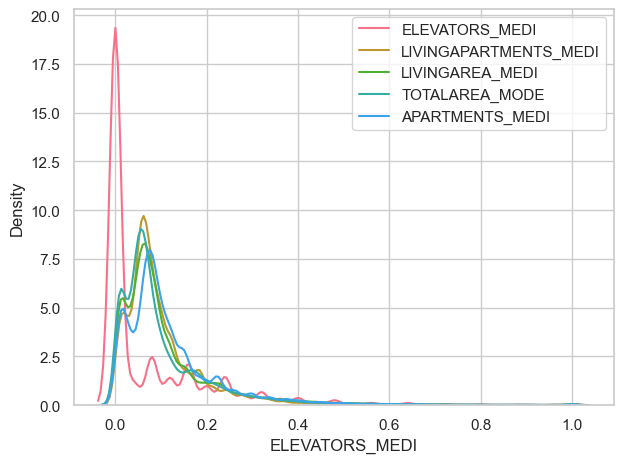

In [243]:
for feature in ["ELEVATORS_MEDI", "LIVINGAPARTMENTS_MEDI", "LIVINGAREA_MEDI", "TOTALAREA_MODE", "APARTMENTS_MEDI"]:
    sns.kdeplot(data=application_train, x=feature, label=feature)

plt.tight_layout()
plt.legend()
plt.show()

In [244]:
application_train.drop(columns=["LIVINGAPARTMENTS_MEDI", "LIVINGAREA_MEDI", "APARTMENTS_MEDI"], inplace=True)

In [245]:
application_train.shape

(307511, 91)

In [246]:
application_train.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,NAME_CONTRACT_TYPE_CASH_LOANS
0,100002,1,0,1,0,202500.0,406597.5,24700.5,351000.0,1,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,100004,0,1,1,0,67500.0,135000.0,6750.0,135000.0,1,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,1,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,1,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# AMT_REQ_CREDIT_BUREAU

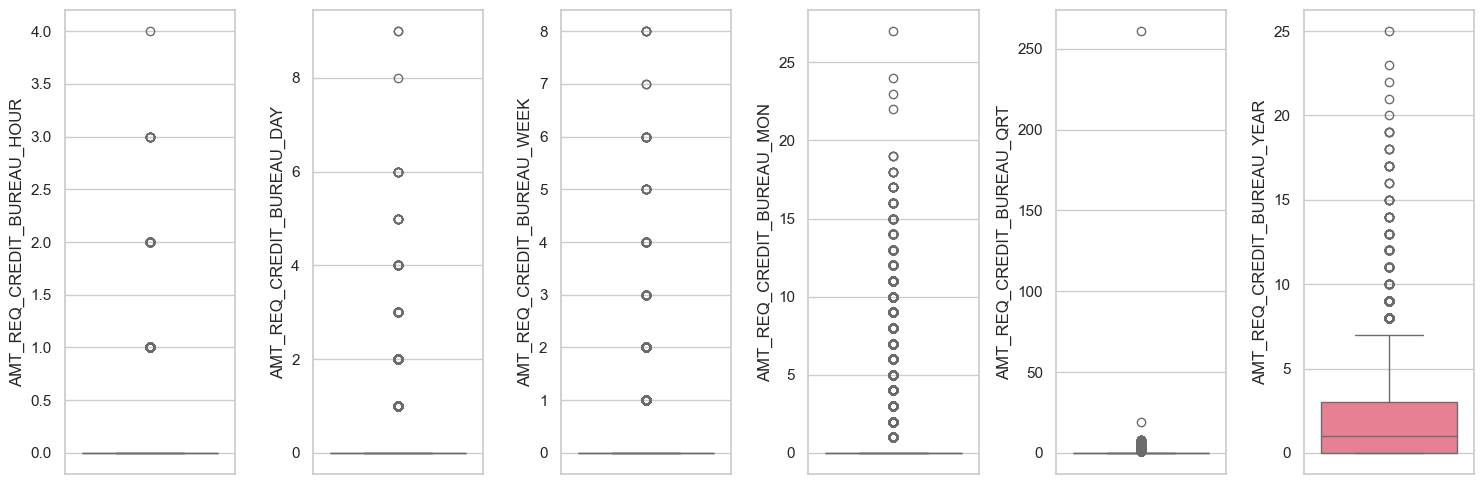

In [190]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

# Iterate over features
for i, feature in enumerate(application_train.filter(like='AMT_REQ_CREDIT_BUREAU_', axis=1).columns):
    sns.boxplot(data=application_train, y=feature, ax=axes[i])

plt.tight_layout()
plt.show()

In [191]:
# application_train[application_train.filter(like='AMT_REQ_CREDIT_BUREAU_', axis=1).columns].isna().sum()

In [192]:
# application_train[[
#     'AMT_REQ_CREDIT_BUREAU_HOUR', 
#     'AMT_REQ_CREDIT_BUREAU_DAY', 
#     'AMT_REQ_CREDIT_BUREAU_WEEK', 
#     'AMT_REQ_CREDIT_BUREAU_MON', 
#     'AMT_REQ_CREDIT_BUREAU_QRT'
#     ]] = application_train[[
#     'AMT_REQ_CREDIT_BUREAU_HOUR', 
#     'AMT_REQ_CREDIT_BUREAU_DAY', 
#     'AMT_REQ_CREDIT_BUREAU_WEEK', 
#     'AMT_REQ_CREDIT_BUREAU_MON', 
#     'AMT_REQ_CREDIT_BUREAU_QRT'
#     ]].map(lambda x: 1 if x >= 1 else 0)

In [193]:
# application_train.filter(like='AMT_REQ_CREDIT_BUREAU_', axis=1).var()

In [194]:
# application_train['AMT_REQ_CREDIT_BUREAU_YEAR'].quantile(0.99)

# Work titles and income source
## Occupation type
Businessman are depicted with only 8 counts, simillarly low rows with Maternity Leave, Pensioner and Student.

In [220]:
application_train[['NAME_INCOME_TYPE', 'TARGET']].value_counts()

NAME_INCOME_TYPE      TARGET
Working               0         143550
Commercial associate  0          66257
Pensioner             0          52380
State servant         0          20454
Working               1          15224
Commercial associate  1           5360
Pensioner             1           2982
State servant         1           1249
Student               0             18
Unemployed            0             14
Businessman           0             10
Unemployed            1              8
Maternity leave       0              3
                      1              2
Name: count, dtype: int64

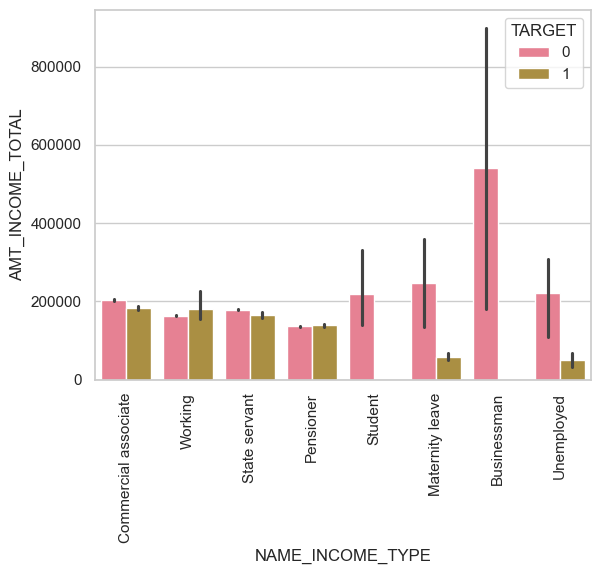

In [196]:
#plt.figure(figsize=(15, 5))

sns.barplot(data=application_train.sample(100000, random_state=42), hue='TARGET', y='AMT_INCOME_TOTAL', x='NAME_INCOME_TYPE')

#plt.yscale('log')
plt.xticks(rotation=90)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Lets examine if NAME_INCOME_TYPE important to TARGET. Low count types (Businessman, Maternity Leave, Pensioner and Student) will be removed, as to not distort the view.

Null Hypothesis (H0): There is no relationship between 'NAME_INCOME_TYPE' and 'TARGET' (excluding usinessman, Maternity Leave, Pensioner and Student). <br>
Alternative Hypothesis (H1): There is a relationship between 'NAME_INCOME_TYPE' and 'TARGET' (excluding usinessman, Maternity Leave, Pensioner and Student).

In [197]:
help_stats.chi_squared_test(application_train, ('NAME_INCOME_TYPE', 'TARGET'))

Chi-squared statistic: 1253.4708080924986. P-value: 1.9281456056861122e-266. Reject the null hypothesis.


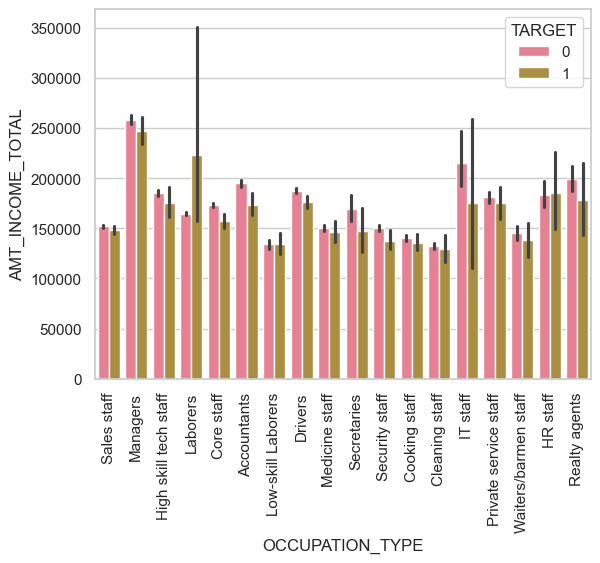

In [204]:
sns.barplot(data=application_train.sample(100000, random_state=42), hue='TARGET', 
            y='AMT_INCOME_TOTAL', x='OCCUPATION_TYPE')

#plt.yscale('log')
plt.xticks(rotation=90)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [208]:
help_stats.chi_squared_test(application_train, ('OCCUPATION_TYPE', 'TARGET'))

Chi-squared statistic: 1402.8467961927515. P-value: 3.7844998567642684e-288. Reject the null hypothesis.


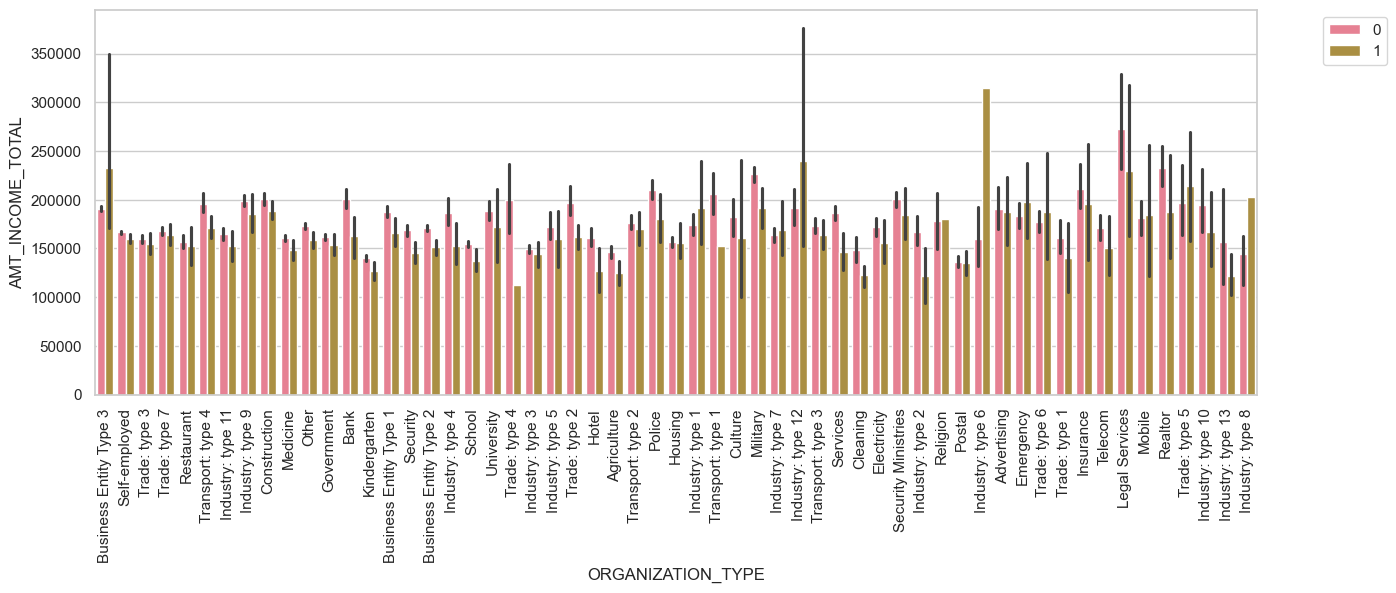

In [157]:
plt.figure(figsize=(15, 5))
sns.barplot(data=application_train.sample(100000, random_state=42), hue='TARGET', y='AMT_INCOME_TOTAL', x='ORGANIZATION_TYPE')

#plt.yscale('log')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [144]:
application_train[application_train['NAME_INCOME_TYPE'] == 'Unemployed'][['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']].drop_duplicates()

,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
1156,Unemployed,NaN,NaN


In [145]:
application_train[application_train['NAME_INCOME_TYPE'] == 'Student'][['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']].drop_duplicates()

,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
10277,Student,Laborers,Business Entity Type 2
16818,Student,NaN,Business Entity Type 2
42679,Student,Waiters/barmen staff,Medicine
48819,Student,Laborers,Electricity
49917,Student,Drivers,Business Entity Type 3
58096,Student,Laborers,Business Entity Type 1
61121,Student,Core staff,Trade: type 6
69971,Student,Laborers,Medicine
89506,Student,Core staff,School
104864,Student,Low-skill Laborers,Other


In [146]:
application_train[application_train['NAME_INCOME_TYPE'] == 'Businessman'][['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']].drop_duplicates()

,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
29666,Businessman,Managers,Self-employed
29737,Businessman,Managers,Bank
87098,Businessman,Core staff,Self-employed
235450,Businessman,NaN,Business Entity Type 3
254641,Businessman,NaN,Self-employed


In [141]:
# pivot_table = application_train.pivot_table(index='ORGANIZATION_TYPE', 
#                                             columns='NAME_INCOME_TYPE', 
#                                             aggfunc='size', 
#                                             fill_value=0)


# plt.figure(figsize=(15, 15))

# sns.heatmap(pivot_table, annot=True, fmt=".0f")
# plt.show()

Unemployed income type has no OCCUPATION_TYPE, but still got a loan. This suggests that OCCUPATION_TYPE is not important for Target.

In [100]:
application_train[application_train['NAME_INCOME_TYPE'] == 'Unemployed']['OCCUPATION_TYPE'].drop_duplicates()

1156    NaN
Name: OCCUPATION_TYPE, dtype: object

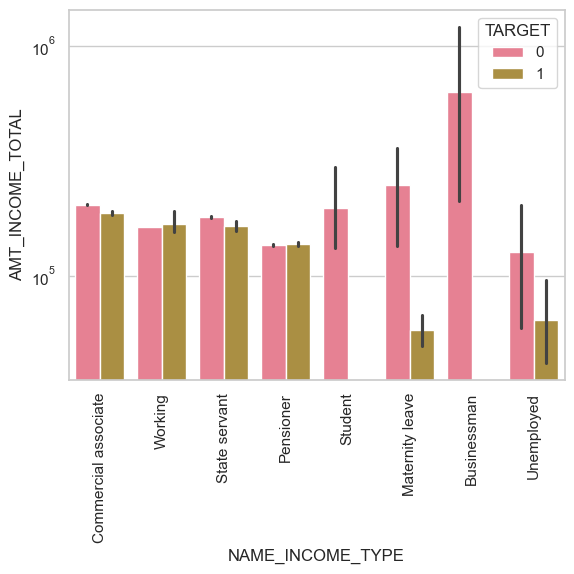

In [101]:
#plt.figure(figsize=(15, 5))

sns.barplot(data=application_train.sample(200000, random_state=42), hue='TARGET', y='AMT_INCOME_TOTAL', x='NAME_INCOME_TYPE')

plt.yscale('log')
plt.xticks(rotation=90)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

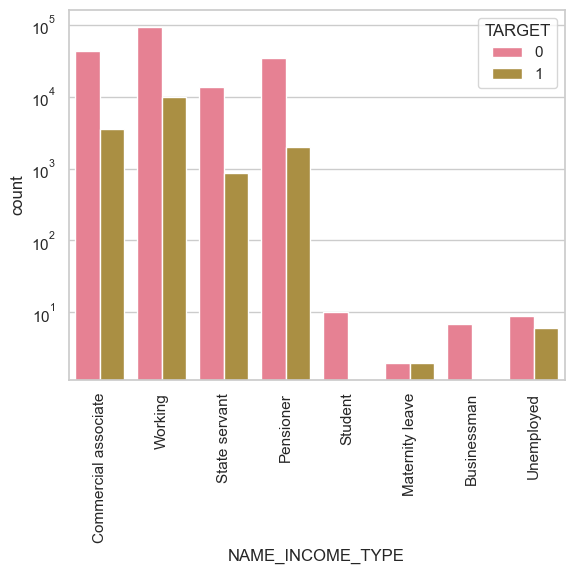

In [102]:
#plt.figure(figsize=(15, 5))

sns.countplot(data=application_train.sample(200000, random_state=42), hue='TARGET', x='NAME_INCOME_TYPE')

plt.yscale('log')
plt.xticks(rotation=90)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

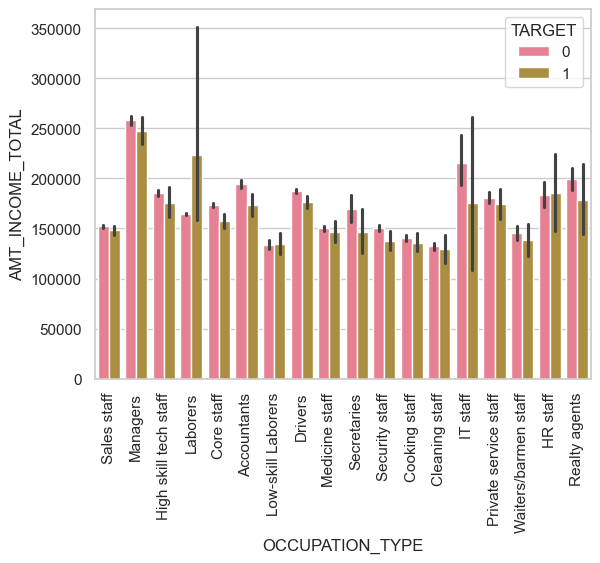

In [76]:
sns.barplot(data=application_train.sample(100000, random_state=42), hue='TARGET', y='AMT_INCOME_TOTAL', x='OCCUPATION_TYPE')

plt.xticks(rotation=90)
plt.show()

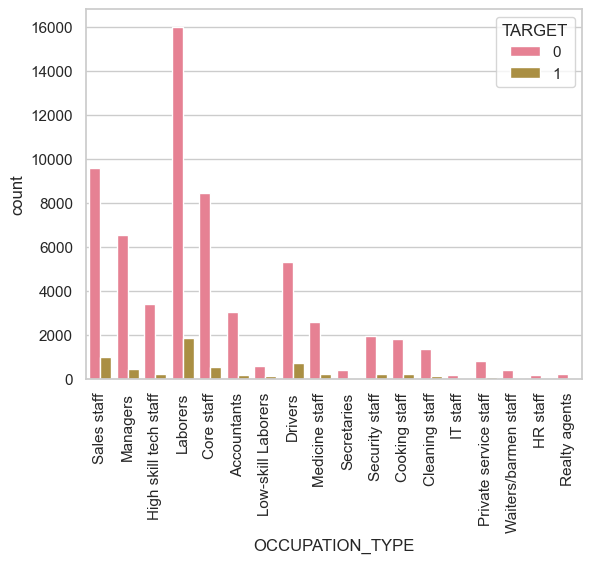

In [77]:
sns.countplot(data=application_train.sample(100000, random_state=42), hue='TARGET', x='OCCUPATION_TYPE')

plt.xticks(rotation=90)
plt.show()

I there a statisticaly significant difference between Occupation types and Loan granting?

In [87]:
help_stats.chi_squared_test(application_train, ('OCCUPATION_TYPE', 'TARGET'))

Chi-squared statistic: 1402.8467961927515. P-value: 3.7844998567642684e-288. Reject the null hypothesis.


In [93]:
help_stats.chi_squared_test(application_train, ('ORGANIZATION_TYPE', 'TARGET'))

Chi-squared statistic: 899.6501407824151. P-value: 1.8427554957590874e-152. Reject the null hypothesis.


In [92]:
help_stats.chi_squared_test(application_train, ('NAME_INCOME_TYPE', 'TARGET'))

Chi-squared statistic: 1253.4708080924986. P-value: 1.9281456056861122e-266. Reject the null hypothesis.


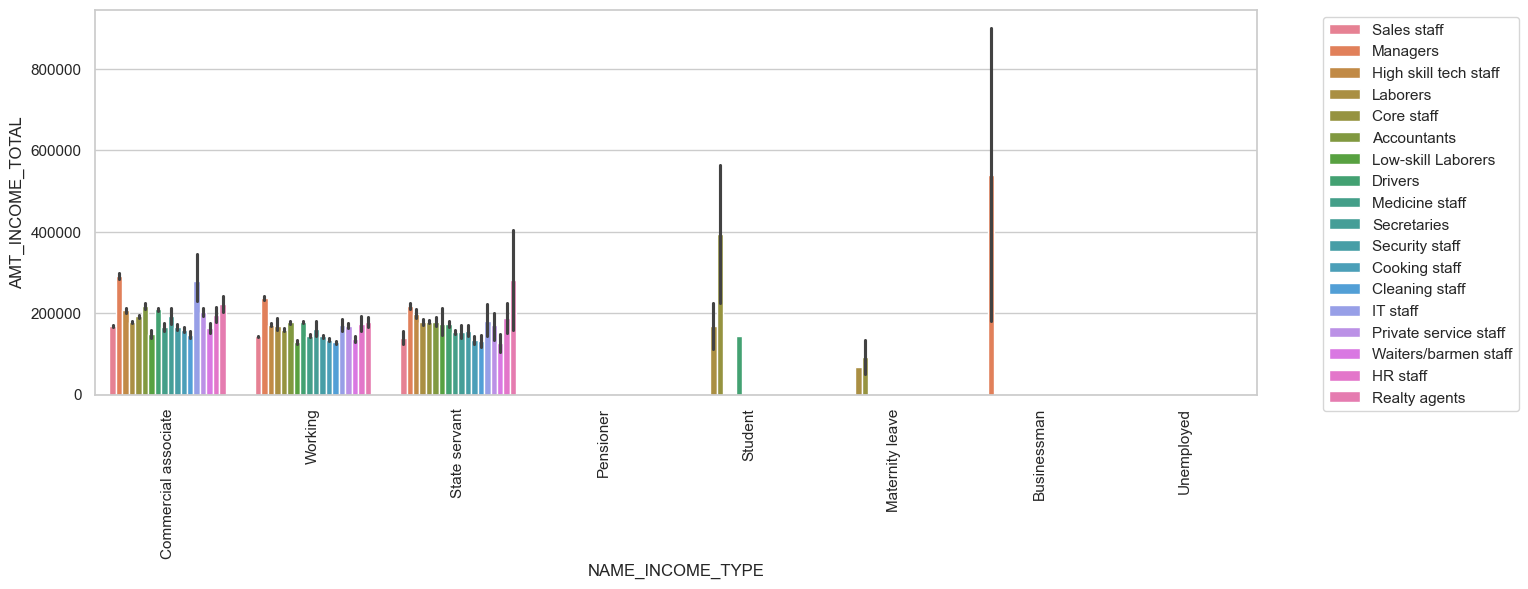

In [75]:
plt.figure(figsize=(15, 5))

sns.barplot(data=application_train.sample(100000, random_state=42), hue='OCCUPATION_TYPE', y='AMT_INCOME_TOTAL', x='NAME_INCOME_TYPE')

#plt.yscale('log')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [90]:
mean_income_per_occupation = application_train.groupby('OCCUPATION_TYPE')['AMT_INCOME_TOTAL'].mean()

# Step 2: Compute the percentile rank of each occupation type
percentiles = mean_income_per_occupation.rank(pct=True)

# Step 3: Bin the percentiles into quartiles
quartiles = pd.qcut(percentiles, q=4, labels=[25, 50, 75, 100])

# Step 4: Map these quartiles back to the original DataFrame
percentiles_dict = quartiles.to_dict()
application_train['OCCUPATION_INCOME_PERCENTILE'] = application_train['OCCUPATION_TYPE'].map(percentiles_dict)


OCCUPATION_INCOME is a description of the income brackets.

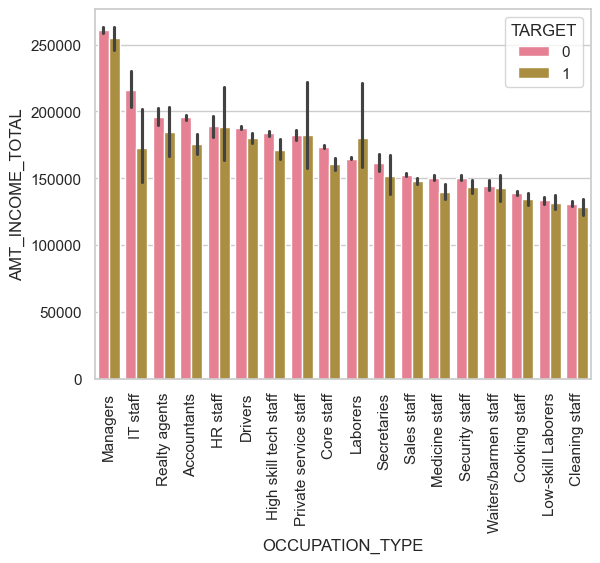

In [91]:
sns.barplot(data=application_train, x='OCCUPATION_TYPE', y='AMT_INCOME_TOTAL', hue='TARGET', order=mean_income_per_occupation.sort_values(ascending=False).index)

#plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [215]:
application_train.drop(columns=['OCCUPATION_INCOME_PERCENTILE', 'OCCUPATION_TYPE'], inplace=True)

Maternaty leave will be cattegorized as working, to avoid discrimination.

In [216]:
application_train['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working       252109
Pensioner      55362
Unemployed        22
Student           18
Name: count, dtype: int64

In [157]:
application_train['NAME_INCOME_TYPE'].replace({'Commercial associate': 'Working', 'Businessman': 'Working', 'State servant': 'Working', 'Maternity leave': 'Working'}, inplace=True)

In [128]:
application_train[['ORGANIZATION_TYPE', 'ORGANIZATION_TYPE_NR']] = (
    application_train['ORGANIZATION_TYPE']
    .str.replace('Type', 'type', regex=False)
    .str.replace(':', '', regex=False)
    .str.rsplit(" type ", n=1, expand=True)
)

# Replace any None with np.nan
application_train = application_train.replace([None], np.nan)

ORGANIZATION_TYPE  
Business Entity        84529
Self-employed          38412
Other                  16683
Trade                  14315
Industry               14311
Medicine               11193
Government             10404
Transport               8990
School                  8893
Kindergarten            6880
Construction            6721
Security                3247
Housing                 2958
Military                2634
Bank                    2507
Agriculture             2454
Police                  2341
Postal                  2157
Security Ministries     1974
Restaurant              1811
Services                1575
University              1327
Hotel                    966
Electricity              950
Insurance                597
Telecom                  577
Emergency                560
Advertising              429
Realtor                  396
Culture                  379
Mobile                   317
Legal Services           305
Cleaning                 260
Religion               

Similarly, industry is also a description of income

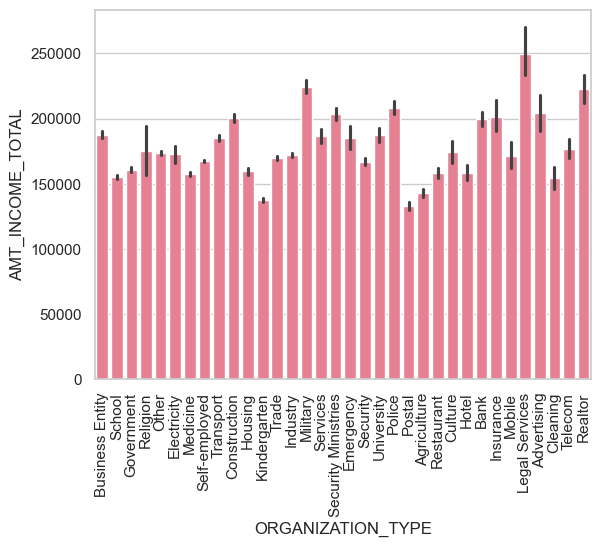

In [214]:
sns.barplot(data=application_train, x='ORGANIZATION_TYPE', y='AMT_INCOME_TOTAL')

#plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [220]:
application_train.drop(columns=['ORGANIZATION_TYPE'], inplace=True)

In [216]:
# Example of unintended large array size
try:
    large_array = np.zeros((47281353805,), dtype=object)
except MemoryError:
    print("Memory allocation failed. Check array size.")

# Ensure array size is reasonable
reasonable_size = 1000  # or some other appropriate size
safe_array = np.zeros((reasonable_size,), dtype=object)

Memory allocation failed. Check array size.


In [217]:
X = application_train[['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE']]
X = help_tool.dummy_columns(X, X.columns)

In [218]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

distance_matrix = squareform(pdist(X, metric='hamming'))
clustering = DBSCAN(metric='precomputed')
clusters = clustering.fit_predict(distance_matrix)

MemoryError: Unable to allocate 352. GiB for an array with shape (47281353805,) and data type float64

# FLAG_DOCUMENT

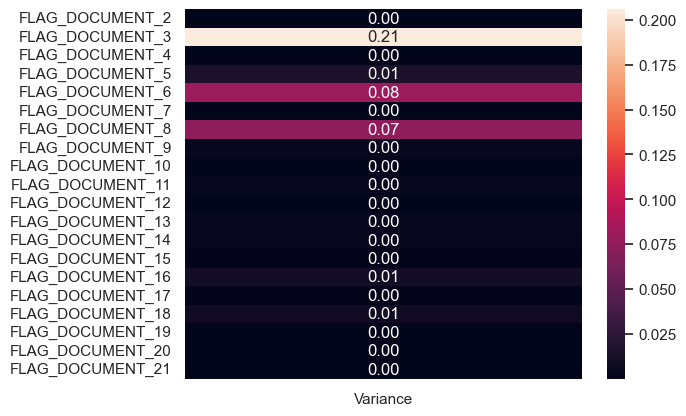

In [221]:
sns.heatmap(data=application_train.filter(like='FLAG_DOCUMENT_', axis=1).var().to_frame().rename(columns={0: 'Variance'}), annot=True, fmt='.2f')
plt.show()

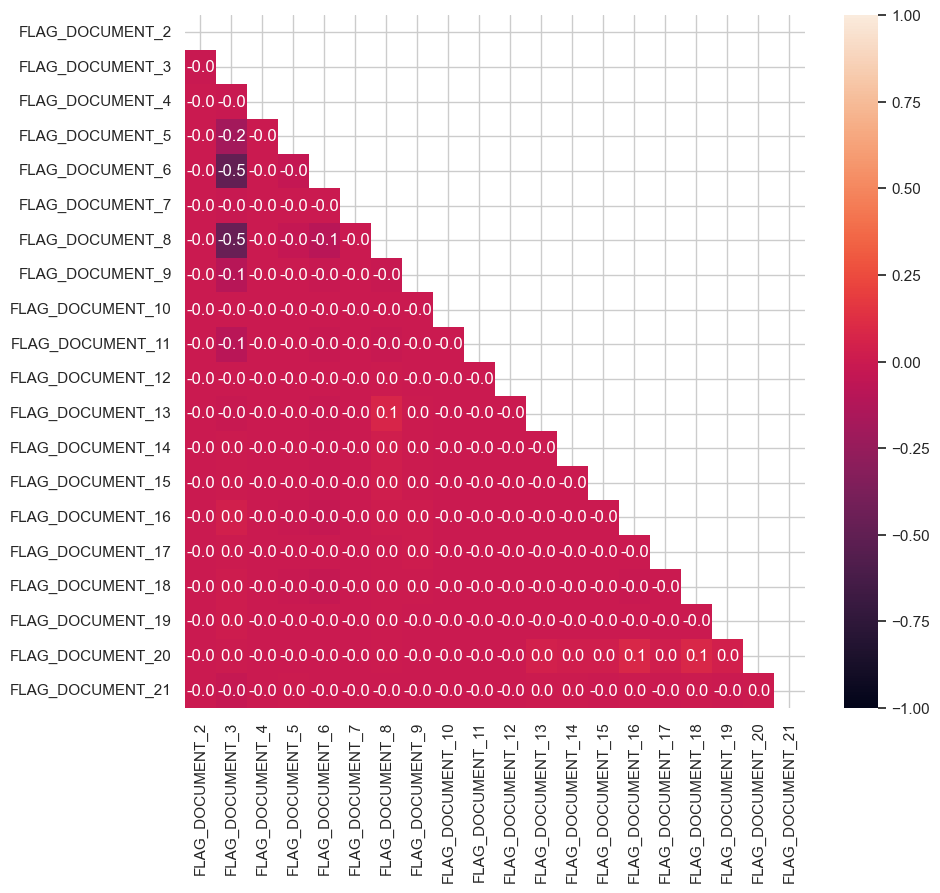

In [50]:
plt.figure(figsize=(10, 9))

corr = application_train[application_train.filter(like='FLAG_DOCUMENT_', axis=1).columns.to_list()].corr(method='spearman')

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=np.triu(corr), fmt='.1f')
plt.show()

In [51]:
application_train.filter(like='FLAG_DOCUMENT_', axis=1).columns.to_list()#.remove('FLAG_DOCUMENT_3')

['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

# Light XGB

In [55]:
object_columns = application_train.select_dtypes(include=['object']).columns.tolist()
application_train_w_dummies = help_tool.dummy_columns(application_train, object_columns)


application_train_w_dummies.columns = application_train_w_dummies.columns.str.replace(',', '_').str.replace(' ', '_')

In [56]:
y = application_train_w_dummies['TARGET']
X = application_train_w_dummies.drop(columns=['TARGET'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
lgb_model = LGBMClassifier(**params, n_estimators=100)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Get feature importances
importance = lgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Display the top 10 most important features
print("Top 10 most important features:")
print(feature_importance.head(10))


Top 10 most important features:
            feature  importance
32     EXT_SOURCE_1         358
34     EXT_SOURCE_3         277
33     EXT_SOURCE_2         261
79      YEARS_BIRTH         216
5        AMT_CREDIT         203
7   AMT_GOODS_PRICE         165
6       AMT_ANNUITY         154
13  DAYS_ID_PUBLISH         123
11    DAYS_EMPLOYED         112
14      OWN_CAR_AGE         110


Gender is 12th place in feature importance. Credit models are not allowed to discriminate against gender.

In [57]:
feature_importance.head(20).reset_index()

,index,feature,importance
0,32,EXT_SOURCE_1,358
1,34,EXT_SOURCE_3,277
2,33,EXT_SOURCE_2,261
3,79,YEARS_BIRTH,216
4,5,AMT_CREDIT,203
5,7,AMT_GOODS_PRICE,165
6,6,AMT_ANNUITY,154
7,13,DAYS_ID_PUBLISH,123
8,11,DAYS_EMPLOYED,112
9,14,OWN_CAR_AGE,110


In [58]:
feature_importance[feature_importance['importance'] == 0]

,feature,importance
155,HOUSETYPE_MODE_block_of_flats,0
137,ORGANIZATION_TYPE_Police,0
144,ORGANIZATION_TYPE_Security_Ministries,0
143,ORGANIZATION_TYPE_Security,0
170,ORGANIZATION_TYPE_NR_2,0
...,...,...
20,FLAG_EMAIL,0
101,OCCUPATION_TYPE_Cooking_staff,0
96,NAME_HOUSING_TYPE_Office_apartment,0
93,NAME_HOUSING_TYPE_Co-op_apartment,0


In [59]:
application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0.083037,0.262949,0.139376
1,0.311267,0.622246,NaN
2,NaN,0.555912,0.729567
3,NaN,0.650442,NaN
4,NaN,0.322738,NaN
...,...,...,...
307506,0.145570,0.681632,NaN
307507,NaN,0.115992,NaN
307508,0.744026,0.535722,0.218859
307509,NaN,0.514163,0.661024


# Variance

In [60]:
variance = application_train_w_dummies.var()
low_var_features = variance[variance < 0.001].index.to_list()
low_var_features

['REGION_POPULATION_RELATIVE',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Maternity_leave',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'ORGANIZATION_TYPE_Cleaning',
 'ORGANIZATION_TYPE_Legal_Services',
 'ORGANIZATION_TYPE_Religion',
 'ORGANIZATION_TYPE_NR_10',
 'ORGANIZATION_TYPE_NR_13',
 'ORGANIZATION_TYPE_NR_8']

No instances are missing for FLAG_DOCUMENT

In [61]:
filtered_columns = application_train.filter(like='FLAG_DOCUMENT', axis=1)
filtered_columns.columns[filtered_columns.isna().any()]

Index([], dtype='object')

But for visualization sake, let's create a new dataframe, and replace 0s with NaN. This way, MSNO can be used to visualize client providing document.

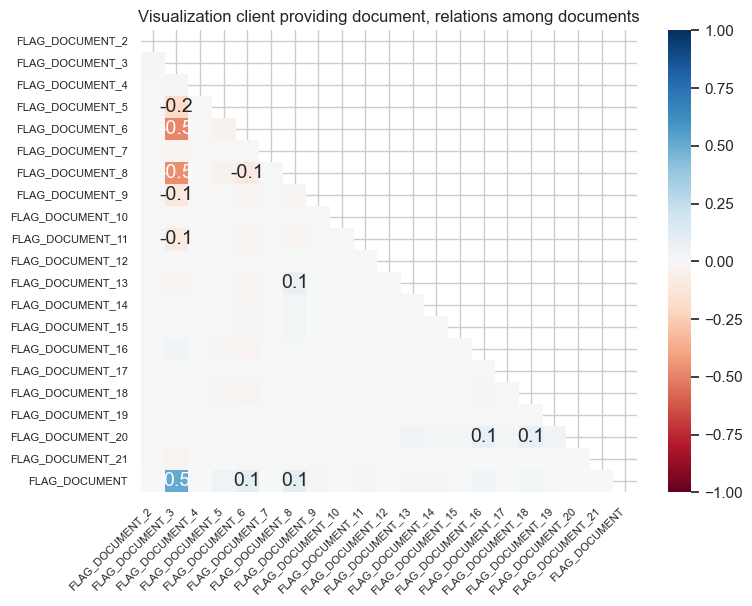

In [62]:
visual_ones = application_train_w_dummies.filter(like='FLAG_DOCUMENT', axis=1).replace(0, np.nan)

msno.heatmap(visual_ones, figsize=(8, 6))
plt.title("Visualization client providing document, relations among documents")

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

In [63]:
application_train_w_dummies.drop(columns=['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21'], inplace=True)

In [64]:
application_train.drop(columns=['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21'], inplace=True)

In [65]:
application_train.shape

(307511, 84)

In [66]:
application_train_w_dummies.shape

(307511, 170)

In [67]:
application_train['FONDKAPREMONT_MODE'].value_counts()

FONDKAPREMONT_MODE
reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: count, dtype: int64

In [68]:
application_train['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
2    218391
4     74863
3     10277
1      3816
5       164
Name: count, dtype: int64

In [69]:
feature_importance.head(30)

,feature,importance
32,EXT_SOURCE_1,358
34,EXT_SOURCE_3,277
33,EXT_SOURCE_2,261
79,YEARS_BIRTH,216
5,AMT_CREDIT,203
7,AMT_GOODS_PRICE,165
6,AMT_ANNUITY,154
13,DAYS_ID_PUBLISH,123
11,DAYS_EMPLOYED,112
14,OWN_CAR_AGE,110


# From the top

In [70]:
application_train.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_BIRTH,CODE_GENDER_F,NAME_CONTRACT_TYPE_CASH_LOANS,FLAG_DOCUMENT,ORGANIZATION_TYPE_NR
0,100002,1,0,1,0,202500.0,406597.5,24700.5,351000.0,1,...,0,0,0,0,1.0,25.9,0.0,1.0,1,3
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0,...,0,0,0,0,0.0,45.9,1.0,1.0,1,NaN
2,100004,0,1,1,0,67500.0,135000.0,6750.0,135000.0,1,...,0,0,0,0,0.0,52.2,0.0,0.0,0,NaN
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,1,...,0,0,0,0,NaN,52.1,1.0,1.0,1,3
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,1,...,0,0,0,0,0.0,54.6,0.0,1.0,1,NaN


In [71]:
application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEA

In [72]:
application_train.filter(like='_MODE', axis=1)

,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,reg oper account,block of flats,0.0149,"Stone, brick",0.0
1,reg oper account,block of flats,0.0714,Block,0.0
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
307506,reg oper account,block of flats,0.2898,"Stone, brick",0.0
307507,reg oper account,block of flats,0.0214,"Stone, brick",0.0
307508,reg oper account,block of flats,0.7970,Panel,0.0
307509,NaN,block of flats,0.0086,"Stone, brick",0.0


In [73]:
application_train['FONDKAPREMONT_MODE'].value_counts()

FONDKAPREMONT_MODE
reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: count, dtype: int64

In [74]:
application_train[application_train['FONDKAPREMONT_MODE'] == 'not specified']

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_BIRTH,CODE_GENDER_F,NAME_CONTRACT_TYPE_CASH_LOANS,FLAG_DOCUMENT,ORGANIZATION_TYPE_NR
202,100235,0,0,1,0,135000.0,364896.0,19926.0,315000.0,1,...,0,0,0,0,2.0,43.5,1.0,1.0,1,NaN
241,100281,0,0,1,1,112500.0,675000.0,21906.0,675000.0,1,...,0,0,1,0,1.0,49.2,1.0,1.0,1,NaN
264,100304,0,0,1,0,225000.0,675000.0,33750.0,675000.0,1,...,0,0,0,0,0.0,62.4,1.0,0.0,0,3
276,100319,0,0,1,1,135000.0,781920.0,32868.0,675000.0,1,...,0,0,0,0,1.0,31.9,1.0,1.0,1,3
437,100504,0,0,1,0,157500.0,187704.0,12672.0,148500.0,1,...,0,0,1,0,1.0,50.1,1.0,1.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307254,455971,0,0,1,0,274500.0,746280.0,54436.5,675000.0,1,...,0,0,1,0,3.0,52.7,0.0,1.0,1,NaN
307277,455994,0,1,1,0,270000.0,536917.5,32976.0,463500.0,1,...,0,0,0,1,2.0,47.6,0.0,1.0,1,NaN
307438,456176,1,0,1,0,171000.0,1436850.0,42142.5,1125000.0,1,...,0,0,0,1,2.0,30.9,0.0,1.0,1,NaN
307476,456216,0,0,0,2,135000.0,1762110.0,48456.0,1575000.0,1,...,0,0,0,0,1.0,37.8,1.0,1.0,1,NaN


<Axes: xlabel='FLOORSMAX_MEDI', ylabel='Count'>

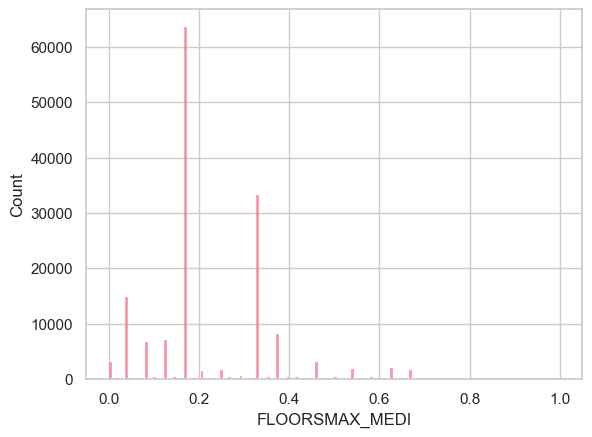

In [75]:
sns.histplot(application_train['FLOORSMAX_MEDI'])

<Axes: xlabel='FLOORSMIN_MEDI', ylabel='Count'>

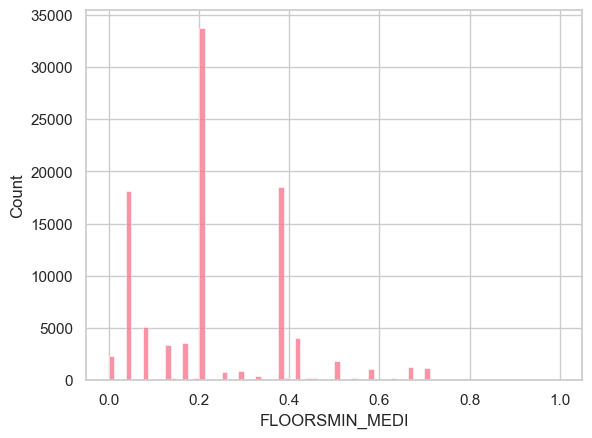

In [76]:
sns.histplot(application_train['FLOORSMIN_MEDI'])

In [77]:
application_train[['FLOORSMIN_MEDI', 'FLOORSMAX_MEDI']]

,FLOORSMIN_MEDI,FLOORSMAX_MEDI
0,0.1250,0.0833
1,0.3333,0.2917
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
307506,0.2708,0.6042
307507,0.1250,0.0833
307508,0.2083,0.1667
307509,NaN,0.0417


In [78]:
application_train[['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'ORGANIZATION_TYPE_NR']]


,OCCUPATION_TYPE,ORGANIZATION_TYPE,ORGANIZATION_TYPE_NR
0,Laborers,Business Entity,3
1,Core staff,School,NaN
2,Laborers,Government,NaN
3,Laborers,Business Entity,3
4,Core staff,Religion,NaN
...,...,...,...
307506,Sales staff,Services,NaN
307507,NaN,NaN,NaN
307508,Managers,School,NaN
307509,Laborers,Business Entity,1


In [79]:
application_train['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity        84529
Self-employed          38412
Other                  16683
Trade                  14315
Industry               14311
Medicine               11193
Government             10404
Transport               8990
School                  8893
Kindergarten            6880
Construction            6721
Security                3247
Housing                 2958
Military                2634
Bank                    2507
Agriculture             2454
Police                  2341
Postal                  2157
Security Ministries     1974
Restaurant              1811
Services                1575
University              1327
Hotel                    966
Electricity              950
Insurance                597
Telecom                  577
Emergency                560
Advertising              429
Realtor                  396
Culture                  379
Mobile                   317
Legal Services           305
Cleaning                 260
Religion                 

In [80]:
org_chart = application_train.groupby(['ORGANIZATION_TYPE', 'ORGANIZATION_TYPE_NR'])['YEARS_BIRTH'].mean().to_frame().reset_index()

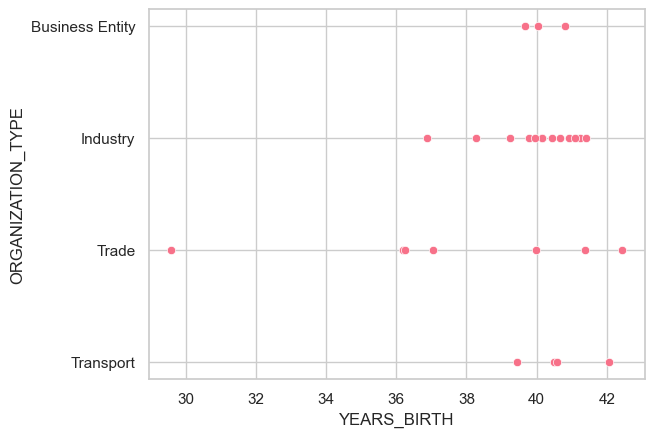

In [81]:
sns.scatterplot(data=org_chart, x='YEARS_BIRTH', y='ORGANIZATION_TYPE'
                #, hue='ORGANIZATION_TYPE_NR'
                )
plt.show()